# Введение в RL

### Авторские права и почиташки: 

* [Непревзайдённый оригинал](http://karpathy.github.io/2016/05/31/rl/) из блога Andrej Karpathy
* Его же [код без tensorflow](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)
* [Другой подход к коду для той же задачки](https://nbviewer.jupyter.org/github/thinkingparticle/deep_rl_pong_keras/blob/master/reinforcement_learning_pong_keras_policy_gradients.ipynb)
* Deep Q-Learning на [Altary games](https://keon.io/deep-q-learning/) в Keras
* Забавный текст про [интуитивный RL](https://habr.com/ru/post/442522/) 

In [ ]:
# !pip install gym  

In [1]:
# !pip install gym[atari]

In [2]:
import gym

In [3]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Библиотека `gym` обычно используется для того, чтобы посимулировать какие-нибудь простенькие проблемы для RL. Внутри `gym` есть куча разных иг. Мы будем использовать `Pong`.

# 1. Посмотрим на игру

Смотрим на игру [по аналогии с документацией.](https://gym.openai.com/docs/) 

In [4]:
env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

(210, 160, 3)

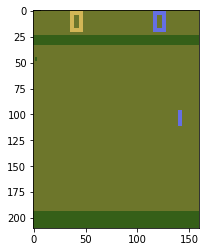

In [5]:
plt.imshow(observation);

У `env` есть много методов. Метод `step` делает какое-то действие. Ноль это обычно бездействие. 

In [6]:
len(env.step(0))

4

После каждого шага мы на выход получаем четыре объекта: 

* `observation` - текущее состояние нашей игры;
* `reward` - вознаграждение за наши действия;
* `done` - завершилась ли игра, и надо ли сбросить настройки и начать заново;
* `info` - полезная второстепенная информация.


In [7]:
for i in range(30):
    obs, rew, dn, inf = env.step(3) # 0 означает ничего не делать 

In [8]:
env.action_space

Discrete(6)

In [9]:
obs.shape

(210, 160, 3)

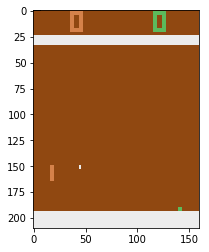

In [10]:
plt.imshow(obs);

In [12]:
rew # ничего не проиграли и не выиграли

0.0

In [13]:
dn  # игра ещё не окончена 

False

In [14]:
inf  # что-то второстепенное и очень полезное...

{'ale.lives': 0}

Среда для игры это ящик  из пикселей. 

In [15]:
env.observation_space

Box(210, 160, 3)

На самом деле можно задавать свои разные среды и как угодно играться с ними, но мы не будем. Давайте лучше выберем какое-нибудь рандомное действие. 

In [16]:
env.action_space.sample()

0

А после аопробуем сыграть партию со случайной стратегией.  Ради фана можно попробовать другие игры: [`MsPacman-v0`](https://gym.openai.com/envs/MsPacman-v0/) или [`MountainCar-v0.`](https://gym.openai.com/envs/MountainCar-v0/)

In [17]:
env_test = gym.make('Pong-v0')   # создали тестовую симуляцию 
env_test.reset()                 # сбросили её до заводских настроек       

for _ in range(1000):
    env_test.render()            # рэндерим! 
    env_test.step(env_test.action_space.sample()) # сделали рандомное действие
env_test.close() # убили симуляцию 

Мы проиграли :(

__Наша задача__ - выучить нейронку, которая будет генрировать последовательность действий, которая приведёт нас к победе над компьютером. 

Вспомним [лекцию.](http://karpathy.github.io/2016/05/31/rl/) В ней говорилось, что лучше бы сделать финт ушами и на вход нейронке подавать не голые изображения, а разницу в пикселях между текущим состоянием среды и будущим. Давайте напишем функцию, которая будет считать такие разницы: 

In [18]:
def preprocess_frames(new_frame, last_frame):
    
    # На вход идёт две картинки 
    n_frame = new_frame.astype(np.int32)
    l_frame = last_frame.astype(np.int32)
    
#   n_frame[(n_frame==144)|(n_frame==109)]=0 # удаляем фон
#   l_frame[(l_frame==144)|(l_frame==109)]=0 # удаляем фон 
    
    # находим разницу 
    diff = n_frame - l_frame
    
    # обрезаем лишние части изображения
    diff = diff[35:195]
    
    # down sample 
    diff=diff[::2,::2]
    
    # превратим картинку в серую и одномерную
    diff = diff[:,:,0] * 299. / 1000 + diff[:,:,1] * 587. / 1000 + diff[:,:,2] * 114. / 1000
    
    # rescale numbers between 0 and 1
    max_val = diff.max() if diff.max() > abs(diff.min())  else abs(diff.min())
    
    if max_val != 0:
        diff=diff/max_val
    return diff

In [19]:
# Сделаем шаг игры 
new_obs, rew, dn, inf = env.step(2)

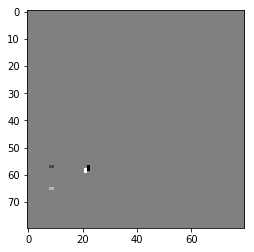

In [20]:
plt.imshow(preprocess_frames(new_obs, obs), cmap='gray');

In [21]:
diff = preprocess_frames(new_obs, obs)
diff

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
diff.shape

(80, 80)

# 2. Модель

Прикрутим модель к среде. Наша первая модель будет очень простой полносвязной сеткой. 

In [23]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential

model = Sequential()

# На вход в сетку пойдет картинка
model.add(L.Input(shape=(80,80)))
model.add(L.Flatten())
    
model.add(L.Dense(units=200, activation='relu', 
                  kernel_initializer='glorot_uniform'))

model.add(L.Dense(units=1, activation='sigmoid', 
                  kernel_initializer='RandomNormal'))

# Компилирует модель
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               1280200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,280,401
Trainable params: 1,280,401
Non-trainable params: 0
_________________________________________________________________


# 3. Модель взаимодействует с игрой

Давайте вытащим из модели предсказание. Если она выплюнет $1$, будем идти вверх. Если $0$, вниз. 

In [24]:
# действия, которые мы можем предпринять 
UP_ACTION = 2
DOWN_ACTION = 3

# для накопления обучающей выборки
y_train = [ ]
x_train = [ ]

# награды на каждом шаге и суммарная
rewards = [ ]
reward_sum = 0 

In [25]:
diff.shape

(80, 80)

In [26]:
diff[np.newaxis,:,:].shape

(1, 80, 80)

In [27]:
# Пробуем предсказать что должен сделать игрок в текущем состоянии игры
proba = model.predict(diff[np.newaxis,:,:])
proba

array([[0.50262237]], dtype=float32)

In [28]:
# Мы пойдём в ... 
action = UP_ACTION if 0.5 < proba else DOWN_ACTION
action

2

In [29]:
# копим обучающую выборку 
y = 1 if action == UP_ACTION else 0

x_train.append(diff)
y_train.append(y)

In [30]:
y_train

[1]

In [31]:
x_train

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [32]:
# делаем один шаг внутри игры 
obs = new_obs
new_obs, rew, dn, inf = env.step(action)

# расчитываем новую разницу
diff = preprocess_frames(new_obs, obs)

# копим награду за один шаг игры
rewards.append(rew)
reward_sum += rew

In [33]:
rewards, reward_sum

([0.0], 0.0)

Такие шаги мы будем делать много-много раз, пока игра не кончится. Если игра закончилась, то есть один из игроков набрал $21$ очко, мы останавливаем симуляцию и начинаем обучать модель.

Обратите внимание, что все наблюдения, которые мы накопили в ходе игры мы будем брать в функцию потерь с разными весами. Для этого в метод `fit` мы подаём аргумент `sample_weight`.  Давайте напишем функцию, которая будет это взвешивание производить. 

In [34]:
def discount_rewards(r, gamma):
    r = np.array(r)                 # наши выигрыши 
    discounted_r = np.zeros_like(r) # дисконты для выигрышей 
    
    # накопление награды 
    running_add = 0 
    
    # идём от последней награды к первой
    for t in reversed(range(0, r.size)): 
        
        # если игра кончилась, сбрасываем накопленную награду
        if r[t] != 0: running_add = 0 
          
        # умножаем накопленную награду на дисконт и плюсуем новую
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
        
    # центрируем и нормируем 
    discounted_r -= np.mean(discounted_r) 
    discounted_r /= np.std(discounted_r)
    
    return discounted_r

# 4. Обучение 

Соединяем все, что было выше в единое целое!  Для начала напишем функцию, которая генерирует нам на выход одну игру. 

In [35]:
# закодировали действия 
UP_ACTION = 2
DOWN_ACTION = 3

# гиперпараметр (дисконт) 
gamma = 0.99

Теперь главный цикл. 

In [36]:
from IPython import display

In [38]:
def generate_episode(verbose=1):
    
    # Инициализировали среду 
    env = gym.make("Pong-v0")

    observation = env.reset()

    # сделали первый шаг игры 
    prev_obs = np.zeros((210, 160, 3))
    obs, rew, dn, inf  = env.step(0)
    
    # пустые вектора для выборок и наград
    x_train, y_train, rewards = [],[],[]

    # немного счётчиков :) 
    reward_sum = 0
    
    while (True):
        # расчитываем разницу
        diff = preprocess_frames(obs, prev_obs)
        prev_obs = obs 

        # предсказали как нужно себя вести (policy)
        proba = model.predict(diff[np.newaxis,:,:])

        # что мы делаем
        action = UP_ACTION if 0.5 < proba else DOWN_ACTION
        y = 1 if action == 2 else 0 # метка класса

        # накопили выборку 
        x_train.append(diff)
        y_train.append(y)

        # сделали ещё шаг игры 
        obs, rew, dn, inf  = env.step(action)
        rewards.append(rew)
        reward_sum += rew
        
        if verbose == 1:
            if len(x_train) % 20 == 0:
                display.clear_output(wait=True)
                plt.imshow(obs)
        
        # если игра закончились, выходим из цикла
        if dn:
            break
    
    return x_train, y_train, rewards, reward_sum

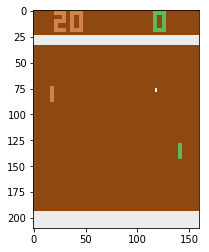

In [39]:
x_train, y_train, rewards, reward_sum = generate_episode()

In [40]:
len(x_train), len(y_train), reward_sum

(1174, 1174, -21.0)

In [41]:
print(y_train[50:150])

[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0]


In [42]:
print(rewards[50:150])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


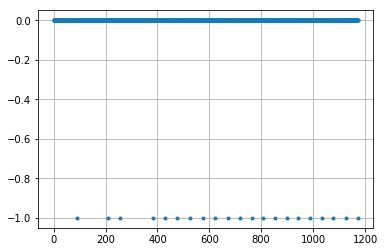

In [43]:
plt.plot(rewards,'.')
ax=plt.gca()
ax.grid(True)

Как выглядит дисконтирование.

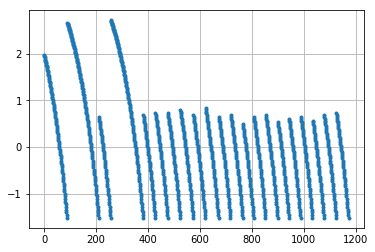

In [44]:
plt.plot(discount_rewards(rewards, gamma),'.')
ax=plt.gca()
ax.grid(True)

Сделаем одну итерацию обучения модели.

In [53]:
# обучаем модель
model.fit(x=np.array(x_train), y=np.vstack(y_train), verbose=1, 
              sample_weight=discount_rewards(rewards, gamma))

Train on 1174 samples
1174/1174 [==============================] - 0s 143us/sample - loss: -9.9557 - accuracy: 0.4404


Сделаем около $100$ таких итераций и посмотрим что получится. 

In [54]:
epochs = 5
for i in range(epochs):
    
    x_train, y_train, rewards, reward_sum = generate_episode(verbose=0)
    
    model.fit(x=np.array(x_train), y=np.vstack(y_train), 
              sample_weight=discount_rewards(rewards, gamma))
    print('Прошла {}-ая игра'.format(i))

Train on 1241 samples
1241/1241 [==============================] - 0s 142us/sample - loss: -0.0241 - accuracy: 0.9492
Прошла 0-ая игра
Train on 1546 samples
1546/1546 [==============================] - 0s 133us/sample - loss: 0.0054 - accuracy: 0.9735
Прошла 1-ая игра
Train on 1103 samples
1103/1103 [==============================] - 0s 137us/sample - loss: -0.0034 - accuracy: 0.9683
Прошла 2-ая игра
Train on 1020 samples
1020/1020 [==============================] - 0s 133us/sample - loss: 0.0045 - accuracy: 0.9794
Прошла 3-ая игра
Train on 1216 samples
1216/1216 [==============================] - 0s 275us/sample - loss: 0.0104 - accuracy: 0.9877
Прошла 4-ая игра


Посмотрим научилась ли чему-то наша небольшая нейронка. 

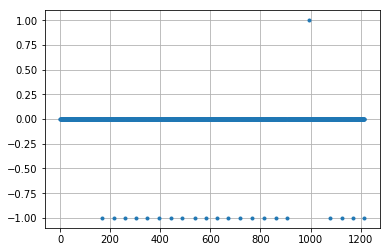

In [55]:
plt.plot(rewards,'.')
ax=plt.gca()
ax.grid(True)

In [ ]:
plt.plot(rewards,'.')
ax=plt.gca()
ax.grid(True)

In [ ]:
plt.plot(discount_rewards(rewards, gamma),'.')
ax=plt.gca()
ax.grid(True)